In [49]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# 1. Configuración de la simulación
---

In [50]:
def setup_simulation(a=1.0, e=0.1, perturba=False):
    """Crea un sistema de 2 cuerpos con/sin perturbación inicial."""
    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.add(m=1.0)  # Estrella central
    
    # Perturbación para cálculo de Lyapunov
    delta = 1e-6 if perturba else 0.0
    sim.add(m=1e-3, a=a + delta, e=e + delta)  # Planeta
    
    sim.integrator = "ias15"
    sim.dt = 0.01
    return sim

# 2. Simulación y recolección de datos
---

In [51]:
def run_simulation(t_max=1e3, N_steps=1000):
    # Simulación nominal
    sim_nominal = setup_simulation(a=1.0, e=0.1)
    times = np.linspace(0, t_max, N_steps)
    
    # Arrays para almacenar datos
    a, e, energy = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)
    
    # Simulación perturbada (para Lyapunov)
    sim_perturbed = setup_simulation(a=1.0, e=0.1, perturba=True)
    a_pert, e_pert = np.zeros(N_steps), np.zeros(N_steps)
    
    # Arrays adicionales para animación
    x = np.zeros((N_steps, 2))
    y = np.zeros((N_steps, 2))
    
    for i, t in enumerate(times):
        # Integrar ambas simulaciones (sin exact_finish)
        sim_nominal.integrate(t)
        sim_perturbed.integrate(t)
        
        # Calcular elementos orbitales usando rebound.Orbit
        orbit_nominal = sim_nominal.particles[1].orbit(sim_nominal.particles[0])
        a[i], e[i] = orbit_nominal.a, orbit_nominal.e
        
        orbit_perturbed = sim_perturbed.particles[1].orbit(sim_perturbed.particles[0])
        a_pert[i], e_pert[i] = orbit_perturbed.a, orbit_perturbed.e
        
        # Energía del sistema
        energy[i] = sim_nominal.energy()
        
        # Almacenar posiciones para animación
        for j in [0, 1]:
            x[i, j] = sim_nominal.particles[j].x
            y[i, j] = sim_nominal.particles[j]. y
    
    return times, a, e, energy, a_pert, e_pert, x, y



# 3. Cálculo de métricas de estabilidad
---

In [52]:
def calculate_stability(times, a, e, energy, a_pert, e_pert):
    # Estabilidad orbital
    delta_a = np.max(a) - np.min(a)
    delta_e = np.max(e) - np.min(e)
    
    # Divergencia y ajuste de Lyapunov (solo en fase lineal)
    delta_orbit = np.sqrt((a - a_pert)**2 + (e - e_pert)**2)
    
    # Limitar a la fase de crecimiento inicial (evitar overflow)
    cutoff = np.argmax(delta_orbit > 1e-3)  # Ajusta este valor según tus datos
    valid = (delta_orbit > 0) & (delta_orbit < 1e-3) & (times < times[cutoff] if cutoff else True)
    
    λ = np.nan
    if np.sum(valid) > 10:  # Mínimo de puntos para ajuste
        def model(t, λ):
            return delta_orbit[valid][0] * np.exp(λ * t)
        
        try:
            params, _ = curve_fit(model, times[valid], delta_orbit[valid], maxfev=5000)
            λ = params[0]
        except:
            pass
    
    # Energía
    energy_rel = np.abs((energy - energy[0])/energy[0])
    
    return {
        "delta_a": delta_a,
        "delta_e": delta_e,
        "lyapunov": λ,
        "energy_var": np.max(energy_rel)
    }

# 4. Visualización
---

In [53]:

def plot_analysis(times, a, e, energy, metrics):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    
    # Órbita
    axs[0,0].plot(times, a, 'b')
    axs[0,0].set_title(f"Semieje Mayor (Δa = {metrics['delta_a']:.2e} AU)")
    axs[0,0].set_ylabel("a (AU)")
    
    axs[0,1].plot(times, e, 'r')
    axs[0,1].set_title(f"Excentricidad (Δe = {metrics['delta_e']:.2e})")
    axs[0,1].set_ylabel("e")
    
    # Energía
    axs[1,0].semilogy(times, np.abs((energy - energy[0])/energy[0]), 'g')
    axs[1,0].set_title(f"Energía Relativa (Máx: {metrics['energy_var']:.2e})")
    axs[1,0].set_ylabel("|ΔE/E₀|")
    
    # Lyapunov
    axs[1,1].semilogy(times, np.sqrt((a - a_pert)**2 + (e - e_pert)**2), 'm')
    axs[1,1].set_title(f"Exponente de Lyapunov: λ = {metrics['lyapunov']:.2e}")
    axs[1,1].set_ylabel("Divergencia")
    
    # Texto resumen
    axs[2,0].axis('off')
    summary_text = (
        "Resumen de Estabilidad:\n"
        f"1. Variación Orbital: Δa = {metrics['delta_a']:.2e} AU, Δe = {metrics['delta_e']:.2e}\n"
        f"2. Exponente de Lyapunov: λ = {metrics['lyapunov']:.2e} (λ > 0 → Caótico)\n"
        f"3. Variación de Energía: {metrics['energy_var']:.2e}"
    )
    axs[2,1].text(0.1, 0.5, summary_text, fontsize=12)
    axs[2,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# 5. Animación 3D
---

In [54]:
def animate_trajectory(x, y, times):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Configuración inicial
    ax.set_title("Órbita 3D en Tiempo Real")
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_zlabel("Z (AU)")
    
    # Elementos de la animación
    star = ax.scatter([], [], [], c='gold', s=100, label='Estrella')
    planet = ax.scatter([], [], [], c='blue', s=30, label='Planeta')
    trail, = ax.plot([], [], [], 'b--', alpha=0.5)
    
    # Determinar límites del eje
    max_range = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_zlim(-max_range, max_range)
    
    def update(frame):
        # Actualizar posiciones
        star._offsets3d = (x[frame, 0:1], y[frame, 0:1], np.zeros(1))
        planet._offsets3d = (x[frame, 1:2], y[frame, 1:2], np.zeros(1))
        
        # Actualizar trayectoria (últimos 100 puntos)
        start = max(0, frame-100)
        trail.set_data(x[start:frame, 1], y[start:frame, 1])
        trail.set_3d_properties(np.zeros(frame-start))
        
        ax.set_title(f"Tiempo: {times[frame]:.1f} años")
        return star, planet, trail
    
    ani = FuncAnimation(fig, update, frames=len(times), interval=20, blit=False)
    plt.legend()
    plt.show()

# 5. Ejecución principal
---

/tmp/ipykernel_72781/2952826290.py:16: RuntimeWarning: overflow encountered in exp
  return delta_orbit[valid][0] * np.exp(λ * t)
/home/carbaje/anaconda3/envs/grav2body/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1017: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/tmp/ipykernel_72781/2952826290.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(model, times[valid], delta_orbit[valid], maxfev=5000)
/home/carbaje/anaconda3/envs/grav2body/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


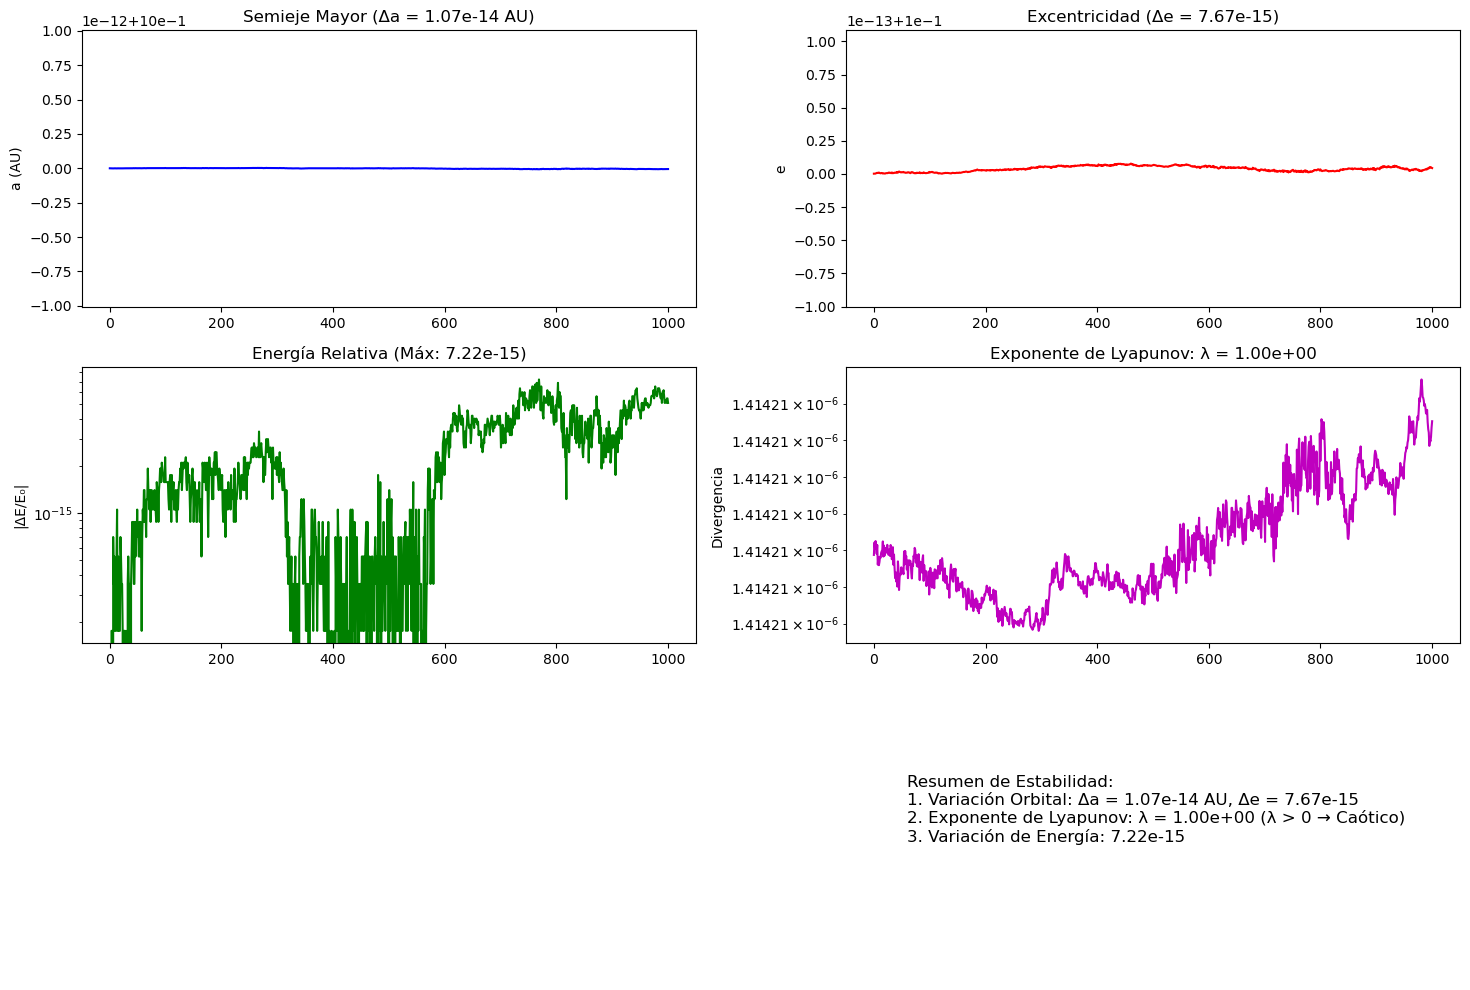

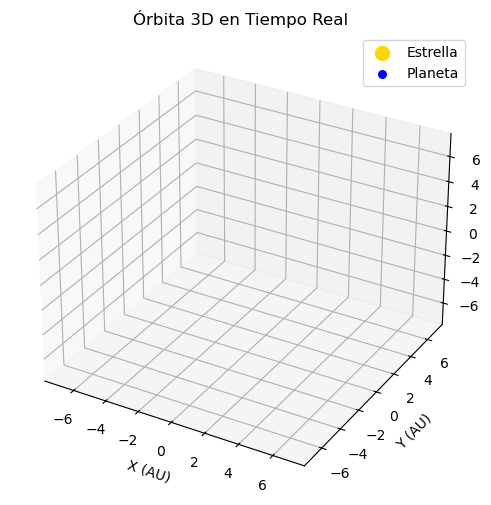

In [55]:
if __name__ == "__main__":
    # Parámetros de simulación
    t_max = 1e3  # Años
    N_steps = 1000
    
    # Ejecutar simulación
    times, a, e, energy, a_pert, e_pert, x, y = run_simulation(t_max, N_steps)
    
    # Calcular métricas
    metrics = calculate_stability(times, a, e, energy, a_pert, e_pert)
    
    # Generar gráficos de análisis
    plot_analysis(times, a, e, energy, metrics)
    
    # Generar animación 3D (en ventana separada)
    animate_trajectory(x, y, times)